In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold

In [4]:
df = pd.read_csv("course_lead_scoring.csv")

In [9]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NA,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NA,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [5]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [10]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [14]:
categorical = list(df.columns[df.dtypes == 'object'])
numerical = list(df.columns[df.dtypes != 'object'])

# If there are missing values:
# For caterogiral features, replace them with 'NA'
# For numerical features, replace with with 0.0

for category in categorical:
    df[category] = df[category].fillna('NA')

for num in numerical:
    df[num] = df[num].fillna(0.0)

df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [42]:
print(categorical)
print(numerical)

['lead_source', 'industry', 'employment_status', 'location']
['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']


In [15]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [16]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values
del df_train['converted']
del df_val['converted']
del df_test['converted']

In [18]:
numerical = list(df_train.columns[df_train.dtypes != 'object'])

dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

/Users/prograsshopper/Library/Caches/pypoetry/virtualenvs/ml-zoomcamp-homework-H2aynh9Z-py3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
# Question 1

features = [
    'lead_score',
    'number_of_courses_viewed',
    'interaction_count',
    'annual_income'
]

scores = []

for feat in features:
    auc = roc_auc_score(y_train, df_train[feat].values)
    scores.append((feat, auc))

scores.sort(key=lambda x: x[1])
scores[-1]

('number_of_courses_viewed', 0.7635680590007088)

In [47]:
# question 2

dicts = df_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

y_pred = predict(df_val, dv, model)

auc = roc_auc_score(y_val, y_pred)

round(auc, 3)

0.817

In [51]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_train[numerical] = scaler.fit_transform(df_train[numerical])
df_val[numerical]   = scaler.transform(df_val[numerical])

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

y_pred = predict(df_val, dv, model)
auc = roc_auc_score(y_val, y_pred)
round(auc, 3)

0.921

In [64]:
# Question 3
# Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
# For each threshold, compute precision and recall
# Plot them

thresholds = np.arange(0.0, 1.01, 0.01)

precisions = []
recalls = []

for t in thresholds:
    decision = (y_pred >= t).astype(int)
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    tp = (actual_positive & (decision == 1)).sum()
    fp = (actual_negative & (decision == 1)).sum()
    fn = (actual_positive & (decision == 0)).sum()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    precisions.append(precision)
    recalls.append(recall)

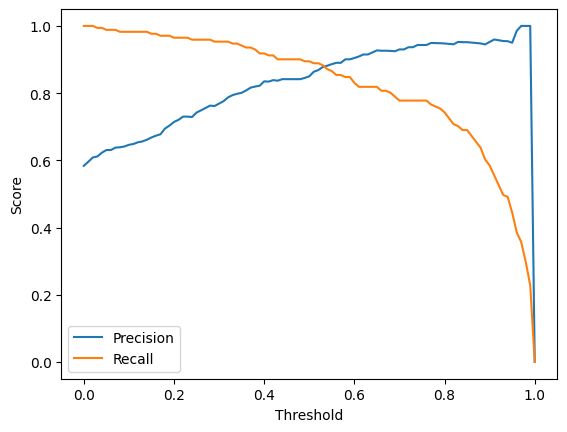

In [66]:
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()

In [69]:
# question 4

def f1_score(precision, recall):
    return 2 * ((precision * recall) / (precision + recall))


thresholds = np.arange(0.0, 1.01, 0.01)
scores = []

for t in thresholds:
    decision = (y_pred >= t).astype(int)
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    tp = (actual_positive & (decision == 1)).sum()
    fp = (actual_negative & (decision == 1)).sum()
    fn = (actual_positive & (decision == 0)).sum()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    scores.append([f1_score(precision, recall), t])

scores.sort(key=lambda x: x[0])
scores[-2]

/var/folders/6g/txmf0w9537n2yz58hrhtwhkh0000gn/T/ipykernel_4639/1007897648.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return 2 * ((precision * recall) / (precision + recall))


[np.float64(0.880466472303207), np.float64(0.53)]

In [75]:
# question 
# 5-Fold

n_splits = 5

def train(df, y_train, C):
    dicts = df[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

C = 1.0
    
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train, C=C)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

/Users/prograsshopper/Library/Caches/pypoetry/virtualenvs/ml-zoomcamp-homework-H2aynh9Z-py3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/prograsshopper/Library/Caches/pypoetry/virtualenvs/ml-zoomcamp-homework-H2aynh9Z-py3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to imp

C=1.0 0.920 +- 0.012


/Users/prograsshopper/Library/Caches/pypoetry/virtualenvs/ml-zoomcamp-homework-H2aynh9Z-py3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [73]:
np.mean(scores), np.std(scores)

(np.float64(0.9201725383969384), np.float64(0.011513248403847955))

In [78]:
from tqdm.auto import tqdm

n_splits = 5


C_mean_std = []
for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores = []
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.converted.values
        y_val = df_val.converted.values
    
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    C_mean_std.append([C, np.mean(scores), np.std(scores)])

  0%|          | 0/3 [00:00<?, ?it/s]

/Users/prograsshopper/Library/Caches/pypoetry/virtualenvs/ml-zoomcamp-homework-H2aynh9Z-py3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/prograsshopper/Library/Caches/pypoetry/virtualenvs/ml-zoomcamp-homework-H2aynh9Z-py3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to imp

In [79]:
C_mean_std.sort(key=lambda x:x[2])
C_mean_std[-1]

[1e-06, np.float64(0.5606368172975525), np.float64(0.023973568035497696)]